In [3]:
%load_ext autoreload
%autoreload 0

In [4]:
%autoreload

In [5]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [6]:
import sfacts as sf
import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr

from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib as mpl

In [7]:
focal_species = 100186

In [8]:
m = sf.data.Metagenotypes.load(f'data/ucfmt.sp-{focal_species}.metagenotype.filt-poly05-cvrg05.nc').to_estimated_genotypes(pseudo=1e-10)
g = sf.data.Metagenotypes.load(f'data/ucfmt.sp-{focal_species}.derep.genotype.nc').select_samples_with_coverage(0.01).to_estimated_genotypes(pseudo=1e-10)
w = sf.data.World.load(f'data/ucfmt.sp-{focal_species}.metagenotype.filt-poly05-cvrg05.fit-sfacts15-s40-g500-seed0.world.nc')
f = w.genotypes
print(m.sizes, g.sizes, w.sizes, sep='\n')

position = list(set(g.position.values) & set(f.position.values))
print(len(position))

m, g, f = [x.mlift('sel', position=position) for x in [m, g, f]]

Frozen({'strain': 11, 'position': 7269})
Frozen({'strain': 1, 'position': 2368})
Frozen(SortedKeysDict({'strain': 5, 'sample': 11, 'position': 7269, 'allele': 2}))
609


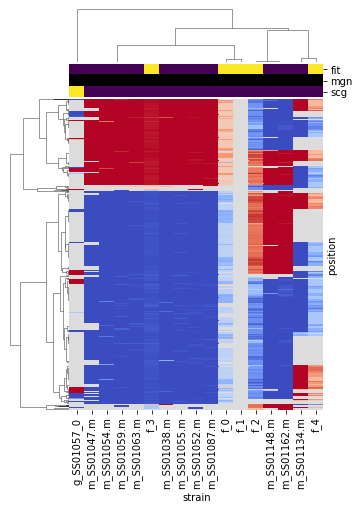

In [9]:
nposition = min(len(position), 1000)
position_ss = m.random_sample(position=nposition).position


together = sf.data.Genotypes.concat(dict(
    m=m,
    g=g,
    f=f,
), dim='strain')

sf.plot.plot_genotype(
    together.mlift('sel', position=position_ss),
    transpose=True,
    row_colors_func=lambda w: xr.Dataset(
        dict(
            fit=w.strain.str.startswith('f_'),
            mgn=w.strain.isin(['m_SS01057.m', 'm_SS01009.m']),
            scg=w.strain.str.startswith('g_'),
        )
    ),
    scalex=1e-2, # if together.sizes['position'] < 1000 else 1e-3,
)

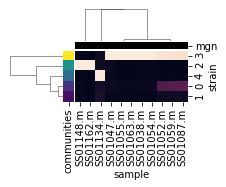

In [10]:
sf.plot.plot_community(
    w,
    col_colors_func=lambda w: xr.Dataset(
        dict(
            mgn=w.sample.isin(['SS01009.m', 'SS01057.m']),
        )
    ),
)

In [21]:
totsf.Metagenotypes.total_counts()

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_post_load',
 'allele_counts',
 'allele_incidence',
 'alt_allele_fraction',
 'concat',
 'constraints',
 'cosine_linkage',
 'cosine_pdist',
 'dims',
 'dominant_allele_fraction',
 'dump',
 'entropy',
 'frequencies',
 'from_counts_and_totals',
 'from_ndarray',
 'lift',
 'linkage',
 'load',
 'load_from_tsv',
 'mean_depth',
 'mlift',
 'pdist',
 'random_sample',
 'safe_unwrapped',
 'select_samples_with_coverage',
 'select_variable_positions',
 'stack',
 'to_counts_and_totals',
 'to_csv',
 'to_estimated_genotypes',
 'to_world',
 'total_counts',
 'validate_constraints',
 'validate_fast',
 'variable_name']

In [11]:
from lib.pandas_util import idxwhere


threshold = 0.01

scg_to_sample = g.strain.to_series().str.split('_').apply(lambda x: x[0]) + '.m'

smallest_fdist_all_strains = sf.match_genotypes(g.to_world(), f.to_world())[1]
smallest_ddist_all_strains = sf.match_genotypes(g.to_world(), f.discretized().to_world())[1]

smallest_fdist_focal_strains = []
smallest_ddist_focal_strains = []
smallest_fdist_focal_mgen = []
smallest_ddist_focal_mgen = []

for focal_sample, d in scg_to_sample.reset_index(name='sample').groupby('sample'):
    focal_sample_scg_list = scg_to_sample[scg_to_sample == focal_sample].index
    focal_sample_strain_list = idxwhere((w.communities.sel(sample=focal_sample) > threshold).to_series())
    smallest_fdist_focal_strains.append(sf.match_genotypes(
        g.mlift('sel', strain=focal_sample_scg_list).to_world(),
        f.mlift('sel', strain=focal_sample_strain_list).to_world()
    )[1])
    smallest_ddist_focal_strains.append(sf.match_genotypes(
        g.mlift('sel', strain=focal_sample_scg_list).to_world(),
        f.mlift('sel', strain=focal_sample_strain_list).discretized().to_world()
    )[1])
    smallest_fdist_focal_mgen.append(sf.match_genotypes(
        g.mlift('sel', strain=focal_sample_scg_list).to_world(),
        m.mlift('sel', strain=[focal_sample]).to_world()
    )[1])
    smallest_ddist_focal_mgen.append(sf.match_genotypes(
        g.mlift('sel', strain=focal_sample_scg_list).to_world(),
        m.mlift('sel', strain=[focal_sample]).discretized().to_world()
    )[1])
    community_entropy_focal_sample = pd.Series(sf.math.entropy(w.communities.values), w.sample)[focal_sample]
#     mgen_horizontal_coverage_focal_sample = 
#     mgen_entropy_focal_sample = m


#     mgen_entropy_focal_sample = pd.Series(sf.math.entropy(m.values), m.strain)[focal_sample]
#     mgen_coverage_focal_sample = 

    
smallest_fdist_focal_strains = pd.concat(smallest_fdist_focal_strains)
smallest_ddist_focal_strains = pd.concat(smallest_ddist_focal_strains)
smallest_fdist_focal_mgen = pd.concat(smallest_fdist_focal_mgen)
smallest_ddist_focal_mgen = pd.concat(smallest_ddist_focal_mgen)

out = pd.DataFrame(dict(
    smallest_fdist_all_strains=smallest_fdist_all_strains,
    smallest_ddist_all_strains=smallest_ddist_all_strains,
    smallest_fdist_focal_strains=smallest_fdist_focal_strains,
    smallest_ddist_focal_strains=smallest_ddist_focal_strains,
    smallest_fdist_focal_mgen=smallest_fdist_focal_mgen,
    smallest_ddist_focal_mgen=smallest_ddist_focal_mgen,
))

out

KeyError: 'SS01057.m'

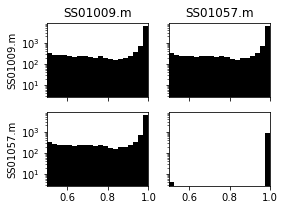

In [142]:
sf.plot.plot_metagenotype_frequency_spectrum(w, sample_list=['SS01009.m', 'SS01057.m'])
plt.yscale('log')

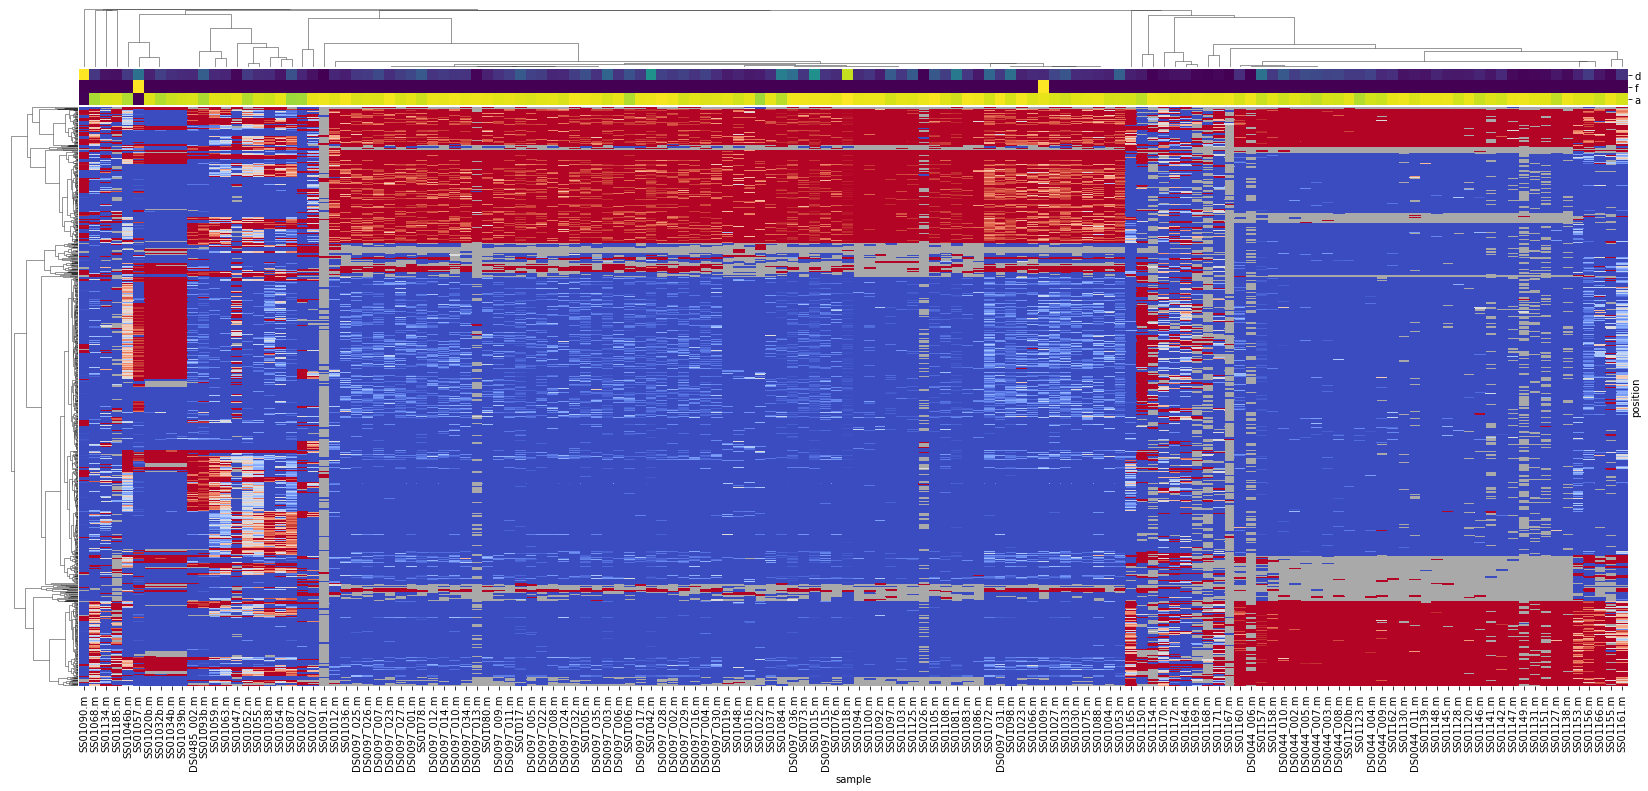

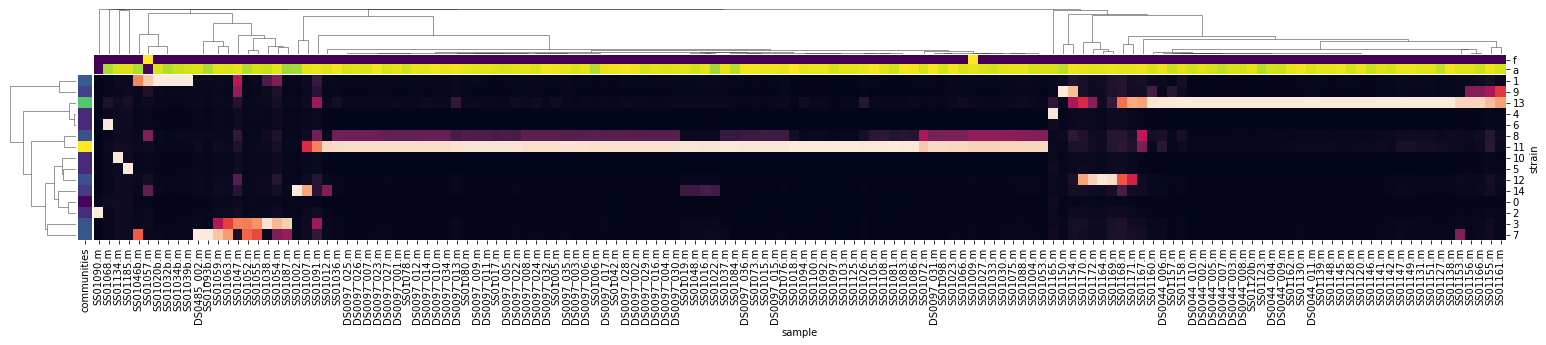

In [82]:
sf.plot.plot_metagenotype2(
    w.random_sample(position=1000),
    col_colors_func=lambda w: xr.Dataset(
        dict(
            d=w.metagenotypes.total_counts().mean("position"),
            f=w.sample.isin(['SS01009.m', 'SS01057.m']),
            a=w.data.alpha,
        )
    ),
    col_linkage_func=lambda w: w.communities.linkage("sample"),
)
sf.plot.plot_community(
    w,
    col_colors_func=lambda w: xr.Dataset(
        dict(
            f=w.sample.isin(['SS01009.m', 'SS01057.m']),
            a=w.data.alpha,
        )
    ),
    col_linkage_func=lambda w: w.communities.linkage("sample"),
#     norm=mpl.colors.PowerNorm(1/1),
)

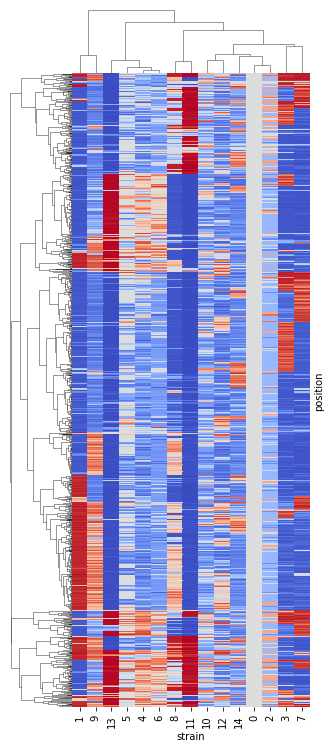

In [74]:
sf.plot.plot_genotype(
    w.random_sample(position=1000),
    transpose=True,
)

In [75]:
droplet_gdist = g.to_estimated_genotypes(pseudo=1e-20).pdist("strain")
SS1009_samples = g.sample[g.sample.str.startswith('SS1009')]
SS1057_samples = g.sample[g.sample.str.startswith('SS1057')]

/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/math.py:26: RuntimeWarning: invalid value encountered in double_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))


In [76]:
droplet_gdist.loc[SS1057_samples, SS1057_samples]

strain,SS1057_ACAATTCGGAGCAAGTCC.d,SS1057_AGTCCGTGTCTACTGTCA.d,SS1057_ATACGAGGTAGATCTTCA.d,SS1057_ATCCGACCATGCATCGGA.d,SS1057_CACTGCTTAATGCGGATT.d,SS1057_CCAATGCCTAGGATCATG.d,SS1057_CCTAAGTCTCTAGAGTCG.d,SS1057_CGGAATGCATCGCGTCAT.d,SS1057_CTGCTGCTTTTAGATCGG.d,SS1057_GAACTATGGTATCAGTGC.d,...,SS1057_GCGTGATACGCCGCCTAA.d,SS1057_GGTTGAAGGGCTCTCCAA.d,SS1057_GTGAGGACGACAATTCGG.d,SS1057_TACGTTACCCCTTCCTCA.d,SS1057_TACGTTACCCTTCCTGAT.d,SS1057_TCCTATTCCATATAGCGT.d,SS1057_TCGATTCAGTTCCTCGGT.d,SS1057_TCGTACCTTGCGAGTCTA.d,SS1057_TTAGGAAGGACGGTGCCT.d,SS1057_TTCGCTGAGATCTGCGTA.d
strain,,,,,,,,,,,,,,,,,,,,,
SS1057_ACAATTCGGAGCAAGTCC.d,0.000000,0.000465,0.025871,0.010086,0.000377,0.005779,0.001257,0.001469,0.000206,0.000416,...,0.001536,0.000028,0.000269,0.000332,0.001130,0.000260,0.000379,0.000392,0.000345,0.000922
SS1057_AGTCCGTGTCTACTGTCA.d,0.000465,0.000000,0.019842,0.009193,0.000439,0.005133,0.001256,0.002336,0.000012,0.000301,...,0.000595,0.000084,0.000423,0.000554,0.004214,0.001098,0.000084,0.000419,0.001138,0.026594
SS1057_ATACGAGGTAGATCTTCA.d,0.025871,0.019842,0.000000,0.005751,0.071723,0.004136,0.009572,0.001218,0.000018,0.009572,...,0.000061,0.000649,0.000000,0.074074,0.025332,0.028518,0.000124,0.031223,0.028719,0.024434
SS1057_ATCCGACCATGCATCGGA.d,0.010086,0.009193,0.005751,0.000000,0.011697,0.000453,0.011754,0.013650,0.000018,0.010472,...,0.000337,0.000040,0.017501,0.020141,0.017709,0.017989,0.058224,0.019094,0.009780,0.000656
SS1057_CACTGCTTAATGCGGATT.d,0.000377,0.000439,0.071723,0.011697,0.000000,0.007102,0.001388,0.001830,0.000000,0.000354,...,0.000000,0.000000,0.000363,0.000412,0.000418,0.000341,0.000084,0.000407,0.000370,0.000102
SS1057_CCAATGCCTAGGATCATG.d,0.005779,0.005133,0.004136,0.000453,0.007102,0.000000,0.007242,0.008091,0.000011,0.006613,...,0.019227,0.000086,0.000489,0.000033,0.005250,0.005841,0.025994,0.005900,0.005549,0.000200
SS1057_CCTAAGTCTCTAGAGTCG.d,0.001257,0.001256,0.009572,0.011754,0.001388,0.007242,0.000000,0.000314,0.000000,0.000209,...,0.000021,0.000000,0.000194,0.000256,0.001256,0.001169,0.000000,0.001286,0.001251,0.000073
SS1057_CGGAATGCATCGCGTCAT.d,0.001469,0.002336,0.001218,0.013650,0.001830,0.008091,0.000314,0.000000,0.000000,0.001650,...,0.002452,0.000000,0.002007,0.002365,0.002459,0.001459,0.000084,0.001613,0.001553,0.000073
SS1057_CTGCTGCTTTTAGATCGG.d,0.000206,0.000012,0.000018,0.000018,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,...,0.000070,0.000000,0.000000,0.000000,0.000040,0.000343,0.000079,0.000966,0.000027,0.000060


In [77]:
droplet_gdist.loc[SS1009_samples, SS1009_samples]

strain,SS1009_AATATCGCTGTGCTAAGC.d,SS1009_AGAATCAGAGTCAATACA.d,SS1009_AGGTGCGAGAGTTATCGC.d,SS1009_AGTGAGAGACATAAGATC.d,SS1009_AGTGAGAGACCATACGAT.d,SS1009_CACTCACTATCTATTAGG.d,SS1009_CCTGCAGATTAAGTACAC.d,SS1009_CTACGAGAACCTTGCTTG.d,SS1009_GCATACATGCCTTGCTTG.d,SS1009_GCGAGCAAGCTGCGTCAC.d,SS1009_GCGAGCAAGTCGCGTCAT.d,SS1009_GCTATGTAACCTTGCTTG.d,SS1009_TATCATGCTACGTGTAGT.d,SS1009_TCACGACAAATCAGAAGC.d
strain,,,,,,,,,,,,,,
SS1009_AATATCGCTGTGCTAAGC.d,0.000000,0.002325,0.001118,0.013837,0.000292,0.001066,0.000380,0.000373,0.001574,0.000345,0.005351,0.001203,0.001019,0.003515
SS1009_AGAATCAGAGTCAATACA.d,0.002325,0.000000,0.001179,0.020870,0.000102,0.001260,0.000410,0.000333,0.001008,0.000200,0.005270,0.001035,0.000899,0.003136
SS1009_AGGTGCGAGAGTTATCGC.d,0.001118,0.001179,0.000000,0.006580,0.000095,0.000474,0.000374,0.000385,0.001084,0.000194,0.004818,0.001597,0.000828,0.004761
SS1009_AGTGAGAGACATAAGATC.d,0.013837,0.020870,0.006580,0.000000,0.001334,0.007693,0.000147,0.000158,0.012896,0.000202,0.031811,0.014290,0.015621,0.012977
SS1009_AGTGAGAGACCATACGAT.d,0.000292,0.000102,0.000095,0.001334,0.000000,0.000215,0.000000,0.000000,0.000257,0.000000,0.021532,0.015152,0.000000,0.007730
SS1009_CACTCACTATCTATTAGG.d,0.001066,0.001260,0.000474,0.007693,0.000215,0.000000,0.000203,0.000126,0.001491,0.000174,0.004286,0.001240,0.000349,0.000222
SS1009_CCTGCAGATTAAGTACAC.d,0.000380,0.000410,0.000374,0.000147,0.000000,0.000203,0.000000,0.000029,0.000427,0.000099,0.003050,0.001222,0.001930,0.000325
SS1009_CTACGAGAACCTTGCTTG.d,0.000373,0.000333,0.000385,0.000158,0.000000,0.000126,0.000029,0.000000,0.000198,0.000062,0.002626,0.001230,0.001366,0.000197
SS1009_GCATACATGCCTTGCTTG.d,0.001574,0.001008,0.001084,0.012896,0.000257,0.001491,0.000427,0.000198,0.000000,0.000278,0.003813,0.001181,0.000931,0.000397


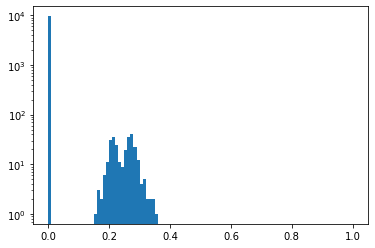

In [39]:
plt.hist(squareform(droplet_gdist.loc[SS1057_samples, SS1057_samples]), bins=np.linspace(0, 1.0, num=101))
plt.yscale('log')
None

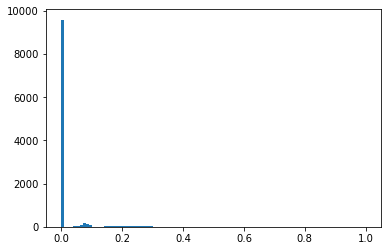

In [27]:
plt.hist(squareform(droplet_gdist), bins=np.linspace(0, 1.0, num=101))
None

/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/plot.py:142: UserWarning: col_linkage calculation failed: Distance matrix 'X' must be symmetric.
  warnings.warn(f"col_linkage calculation failed: {err}")
/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/math.py:26: RuntimeWarning: invalid value encountered in double_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))


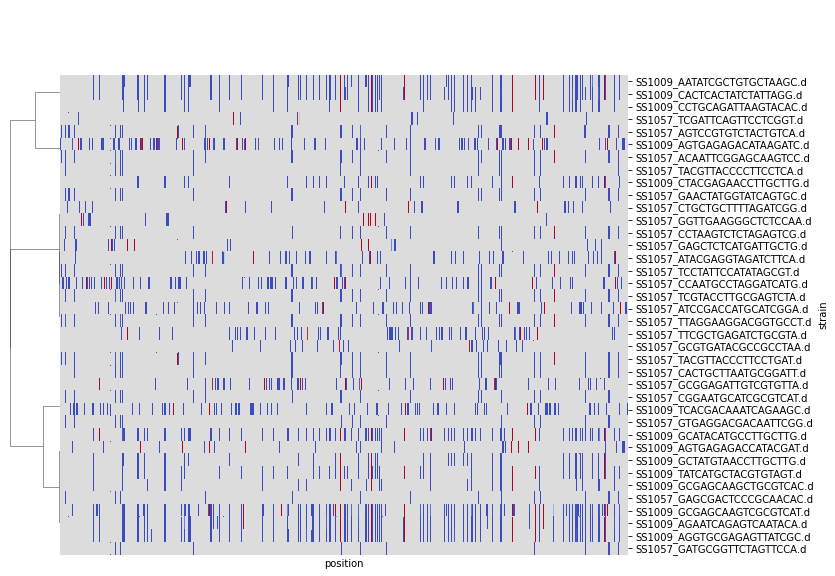

In [85]:
sf.plot.plot_genotype(
    g.to_estimated_genotypes(pseudo=1e-10).random_sample(position=1000)
)

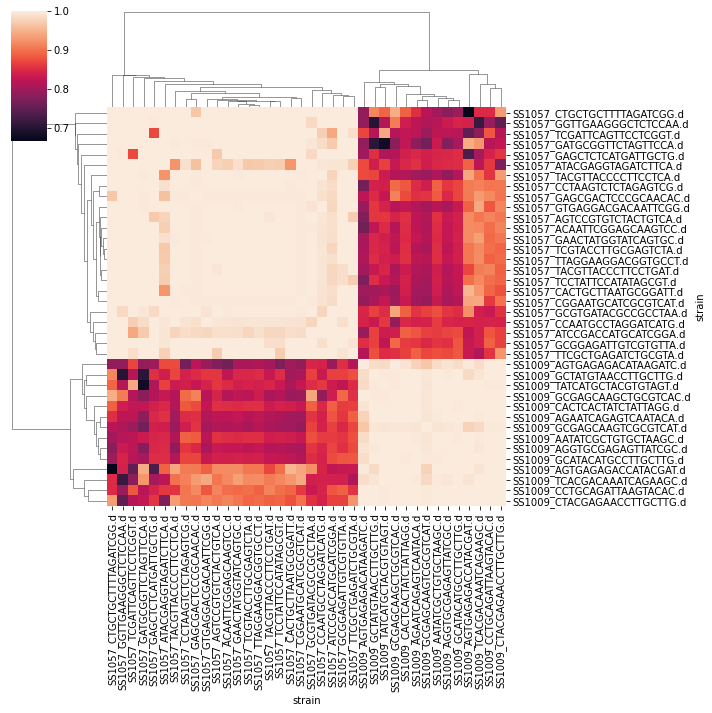

In [84]:
sns.clustermap(1 - droplet_gdist)

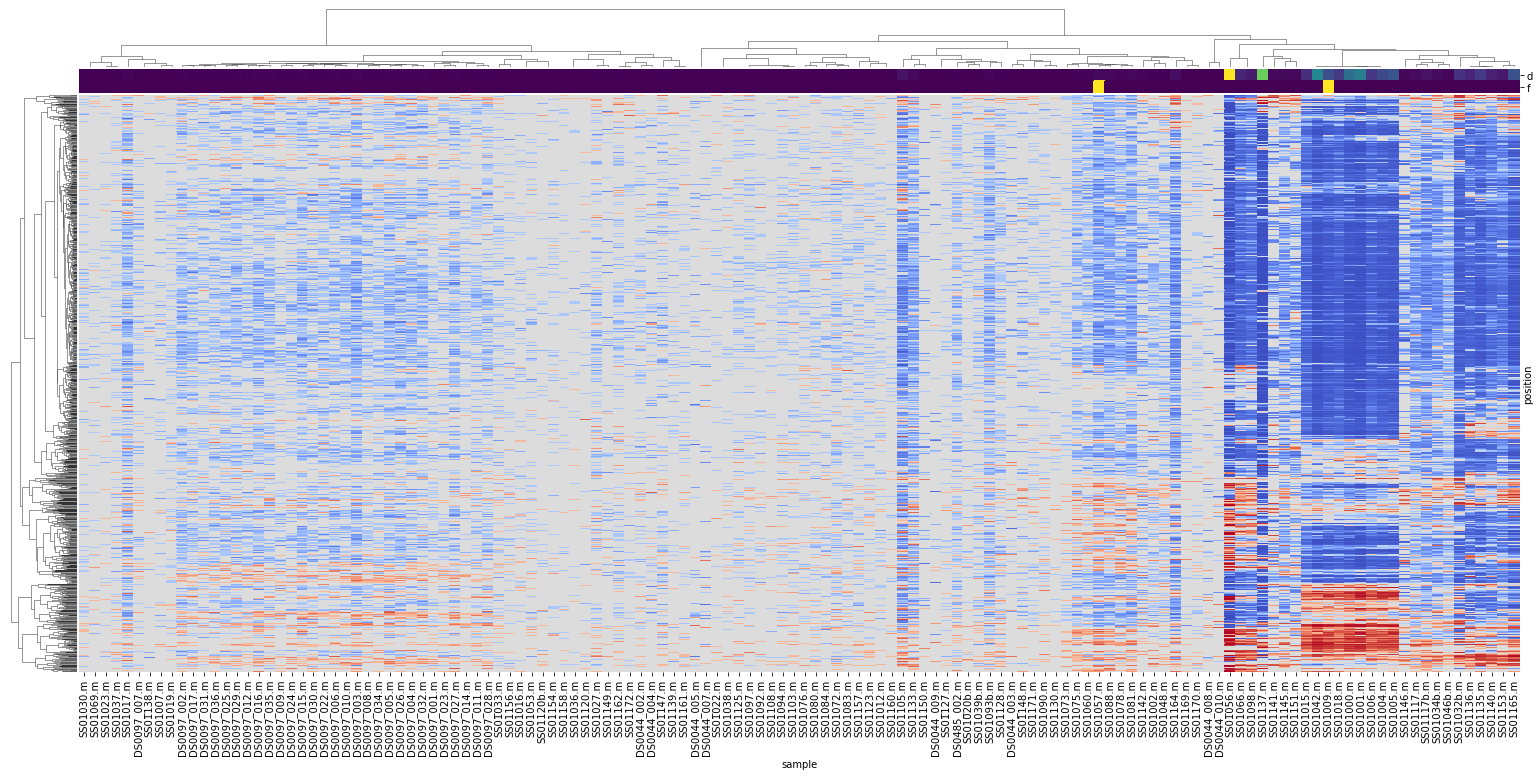

In [91]:
import xarray as xr

sf.plot.plot_metagenotype(
    m.random_sample(position=1000),
    col_colors_func=lambda w: xr.Dataset(
    dict(
        d=w.metagenotypes.total_counts().mean("position"),
        f=w.sample.isin(['SS01009.m', 'SS01057.m']),
    ))
)

/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/math.py:26: RuntimeWarning: invalid value encountered in double_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))
/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/plot.py:154: UserWarning: row_linkage calculation failed: Distance matrix 'X' must be symmetric.
  warnings.warn(f"row_linkage calculation failed: {err}")


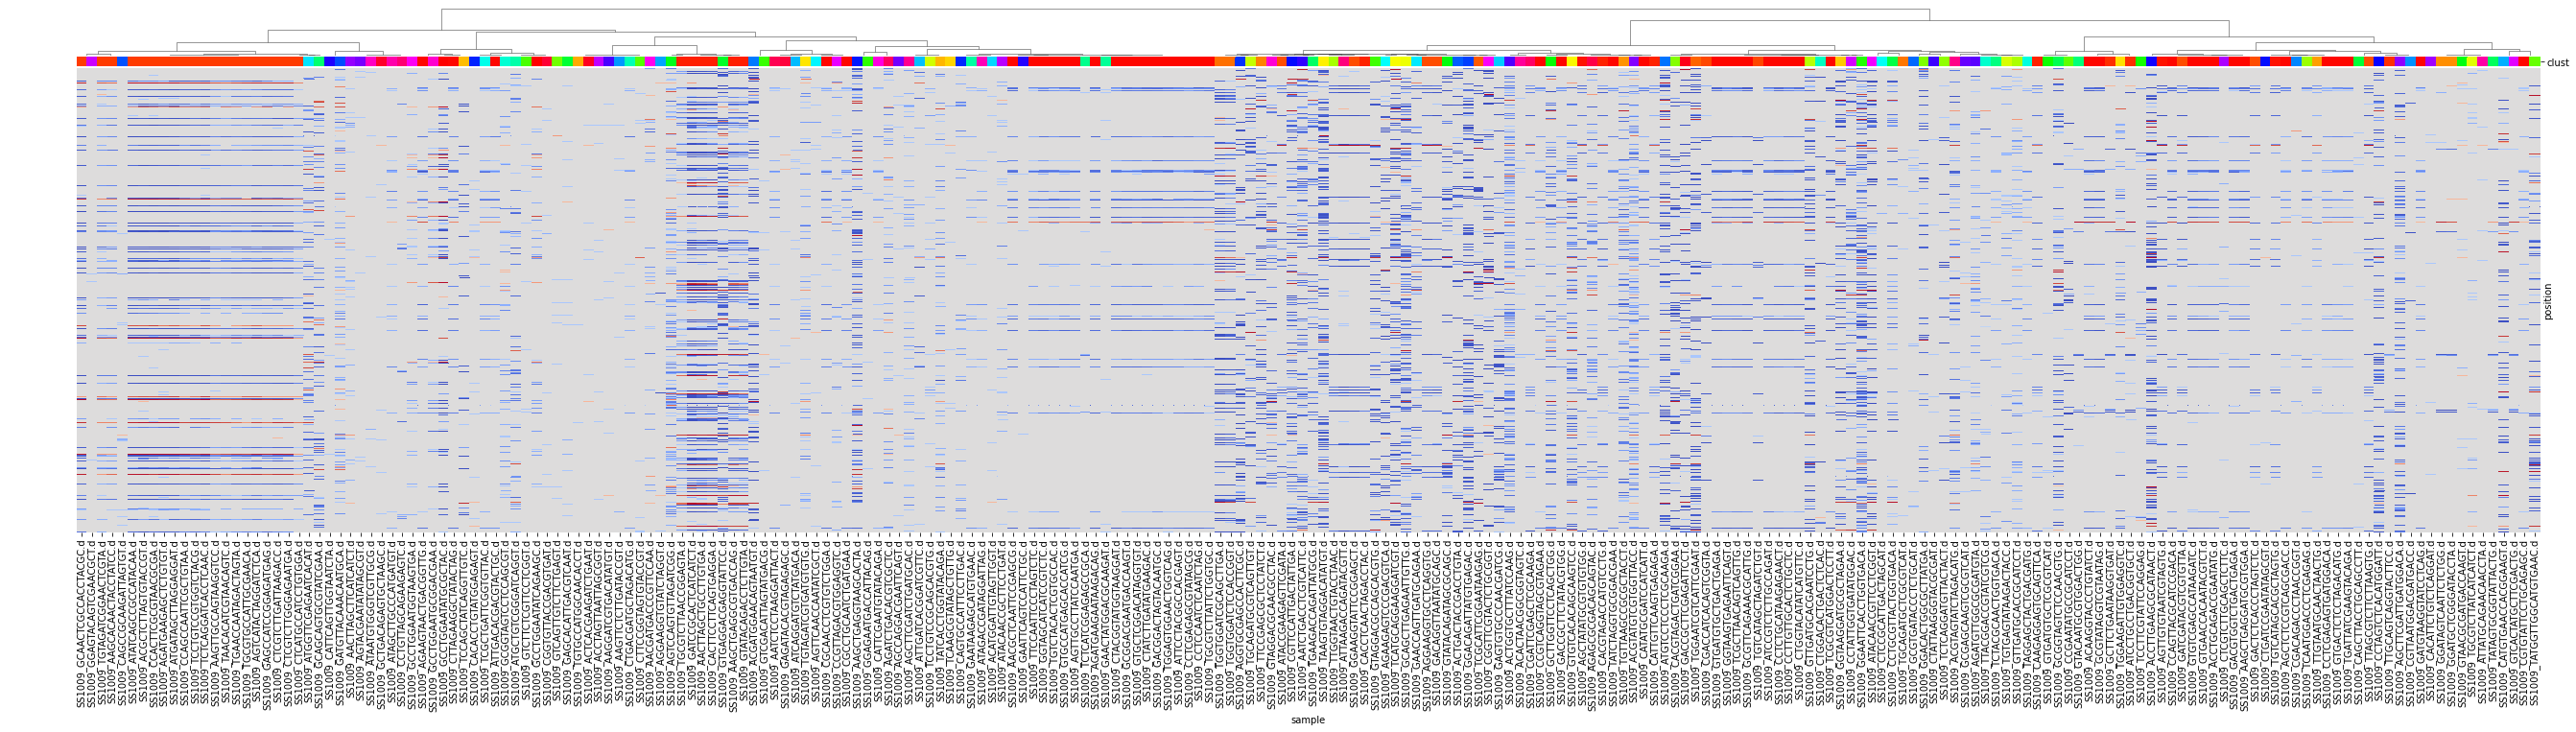

In [42]:
distance_threshold = 0.2

agg = pd.Series(
    (
        AgglomerativeClustering(
            affinity='cosine',
            distance_threshold=distance_threshold,
            n_clusters=None,
            linkage='average'
        )
        .fit_predict(g.total_counts())
    ),
    g.sample,
    name='clust',
)

In [100]:
g = sf.Metagenotypes.load('data/ucfmt.sp-102506.derep.genotype.nc')

/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/math.py:26: RuntimeWarning: invalid value encountered in double_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))
/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/plot.py:154: UserWarning: row_linkage calculation failed: Distance matrix 'X' must be symmetric.
  warnings.warn(f"row_linkage calculation failed: {err}")


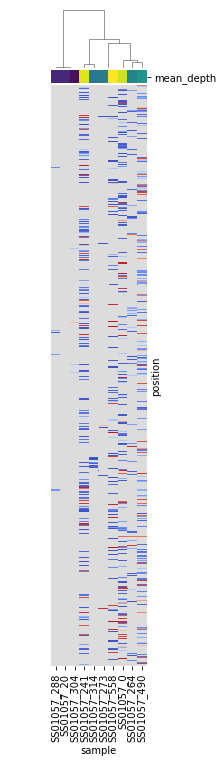

In [102]:
sf.plot_metagenotype(g.select_samples_with_coverage(0.005).random_sample(position=1000))

In [44]:
drplt_derep_ucfmt_104345 = sf.data.Metagenotypes(
    drplt_ucfmt_104345
    .to_series()
    .reset_index()
    .rename(columns={0: 'tally'})
    .join(drplt_agg, on='sample')
    .join(drplt_ucfmt_104345_to_sample.set_index('lib_id'), on='sample')
    .groupby(['sample_id', 'clust', 'position', 'allele'])
    .sum()
    .astype(int)
    .reset_index()
    .assign(label=lambda x: x.sample_id + '_' + x.clust.astype(str))
    .set_index(['label', 'position', 'allele'])
    .rename_axis(index={'label': 'sample'})
    .tally
    .to_xarray()
)
print(drplt_ucfmt_104345.sizes, drplt_derep_ucfmt_104345.sizes)

Frozen({'sample': 238, 'position': 11058, 'allele': 2}) Frozen({'sample': 149, 'position': 11058, 'allele': 2})


In [205]:
%run scripts/compare_inferred_genotypes_to_scgs.py data/ucfmt.sp-104345.metagenotype.filt-poly05-cvrg05.nc data/ucfmt.sp-104345.derep.genotype.nc data/ucfmt.sp-104345.metagenotype.filt-poly05-cvrg05.fit-sfacts15-s40-g500-seed0.world.nc 0.01 data/ucfmt.sp-104345.metagenotype.filt-poly05-cvrg05.fit-sfacts15-s40-g500-seed0.scg_comparison.tsv

<Figure size 432x288 with 0 Axes>